# Trabajo 1 - Organización de datos - Grupo: Grupby['Banco']

## Análisis exploratorio - Zona prop

#### Cargamos las librerias a utilizar.

In [1]:
%matplotlib inline

import cartopy
import cartopy.io.shapereader as shapereader
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt # Plots mas simples
import numpy as np # Trabajo con matrices
import pandas as pd # Trabajo de Dataframes
import scipy.stats as stats
import seaborn as sns # Trabajo con plots estadisticos
import squarify 

from geopandas import GeoSeries, GeoDataFrame
from pandas.tseries.offsets import MonthBegin

#### Dejamos algunas configuraciones ya estandarizadas

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

#### Definimos algunas funciones que nos van a resultar útiles más adelante

In [3]:
def memory(df):
    memory = (df.memory_usage()/(1024*1024)).sum().round(2)
    return memory

#### Levantamos el Dataset (y otros archivos importantes)

In [4]:

# Archivo Zona Prop.
df = pd.read_csv('data/train.csv', index_col=['id'], parse_dates=['fecha'], error_bad_lines=False)

# Archivo Google Trends.
trends = pd.read_csv('data/sentiment_google.csv')
trends['fecha'] = trends.Month.astype(np.datetime64)

# Archivo Inflación de méxico
inflacion_mex = pd.read_csv('./data/inflacion_mex.csv',names=['fecha_mes','indice'],parse_dates=['fecha_mes'],dtype={'indice':np.float64})

# Cargo la serie de inflación.
inflacion_mex = pd.read_csv('data/inflacion_mex.csv',names=['fecha','indice'],parse_dates=['fecha'],dtype={'indice':np.float64})
# Cambio de base al ultimo dato.
infla2019 = inflacion_mex['indice'].tail(1).values[0]
inflacion_mex['indice'] = (inflacion_mex['indice']/infla2019)*100
# Elimino el número de día para poder joinear ambos DF.
df['fecha_ant'] = df.fecha
inflacion_mex['fecha'] = inflacion_mex['fecha'].dt.to_period('M')
df['fecha']= df['fecha'].dt.to_period('M')
df = df.merge(inflacion_mex,how='inner',on='fecha')
df['precio_constantes'] = (df['precio']/df['indice'])*100

# Precio en dolar, con valuación del día 3 de septiembre.
tipo_de_cambio = 0.050 # Cada peso mexicano equivale a esa cantidad de dolares (03/09/2019)
df['precio_usd'] = df['precio'] * tipo_de_cambio # creamos la nueva columna

In [5]:
#Una manera prolija de ver rapidamente las columnas y un ejemplo de los datos en ellas.
#df.head().transpose()

## Consistencia de datos

### Cantidad de NaN/Nulls en cada columna del dataset

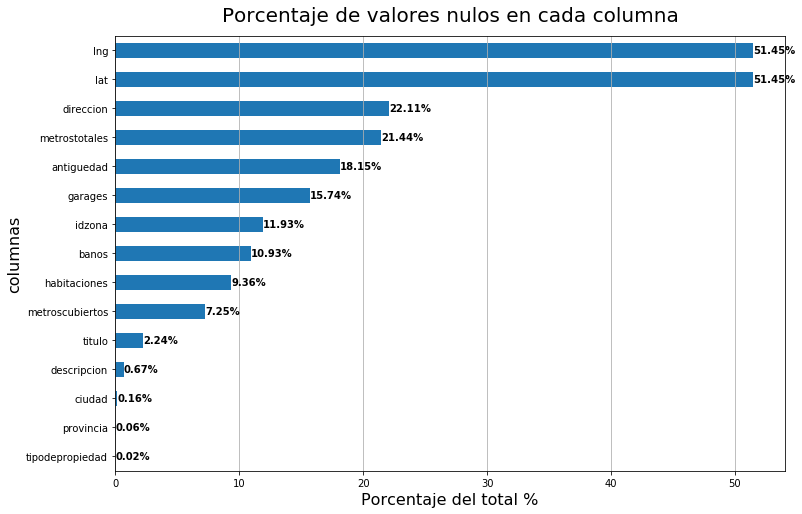

In [6]:
# Hay que ponerlo un poco más bonito pero me parece que ya cumple su función.
nulls = pd.DataFrame((df.isnull().sum().sort_values()/len(df)*100).round(2),columns=['porcentaje de NaN'])
nulls.drop(nulls.loc[nulls.loc[:,'porcentaje de NaN']<=0].index, inplace=True)

ax = nulls['porcentaje de NaN'].plot.barh()
ax.set_title('Porcentaje de valores nulos en cada columna',fontsize=20, y=1.02)
ax.set_xlabel('Porcentaje del total %', fontsize=16)
ax.set_ylabel('columnas', fontsize=16)
ax.grid(axis='x')

for y, x in enumerate(nulls['porcentaje de NaN']):
    ax.text(x, y, s=str(x)+'%', color='black', fontweight='bold',va='center')
    
plt.savefig('images/00-nulls.png')

Empezamos analizando los valores nulos que tenemos en cada columna del dataset. Lo primero que notamos es que hay una cantidad significativa de valores faltantes en latitud y longitud. Creemos que esto se debe a que Navent, la empresa que nos proveyó los datos, los anonimizó y agregó algo de ruido. Lo del ruido es una hipótesis que comprobaremos en los gráficos siguientes.
La "simetría" que tienen estos dos datos es porque son un par coordinado y no sirven el uno sin el otro. Representan un punto en el espacio.

Con respecto a tipodepropiedad,provincia y ciudad eliminaremos las filas ya que son muy pocas y no tienen relevancia estadística.

El título y la descripción, haciendo un análisis sobre el texto, son columnas que no nos aportan más datos de los que ya tenemos en el resto de las columnas del dataset. Aún si hiciésemos el análisis del texto necesario para recopilar más datos que antes no teníamos, creemos que no vale la pena el tiempo invertido.

Lo mismo sucede con la dirección, tendríamos que programar algo que matchee esa dirección con su coordenadas. De la misma manera que antes, tampoco vemos que valga la pena el tiempo invertido.

Con respecto a metroscubiertos y metrototales, vemos que la cantidad de valores nulos empieza a ser significativa. La sustancial diferencia entre ambos valores nos permite reemplazar el uno con el otro y no modificar de manera significativa el dataset. Podemos reducir hasta un 7% de nulls utilizando esta aproximación. En el análisis de estas dos columnas encontramos varias inconsistencias que planteamos y resolvemos en los gráficos siguientes.

Con los datos faltantes en garages, baños y habitaciones intentaremos resolver el problema de los faltantes en al momento de empezar con el armado del modelo predictivo.

Una primera aproximación a este problema, es asignarles la moda por  tipodepropiedad. Asignarle el promedio, no tendría sentido ya que, muy probablemente, nos diera un valor flotante y eso no tendría sentido.
Para esta representación, utilizamos un gráfico de barras horizontal. En el eje de las abscisas, vemos el porcion de nulls sobre el total de los datos de cada columna y en el  eje de ordenadas, los nombres de cada columna.

## Tipos de datos 

#### Sospechamos que hay varias columnas que tienen dtype:float64 pero en realudad son booleanos. Comprombamos viendo si tienen solo dos valores únicos: 0 y 1.

In [7]:
print("Valores únicos piscina: ", df.piscina.unique())
print("Valores únicos usos multiples: ", df.usosmultiples.unique())
print("Valores únicos escuelas cercanas: ", df.escuelascercanas.unique())
print("Valores únicos centros comerciales cercanos: ", df.centroscomercialescercanos.unique())
print("Valores únicos gym: ", df.gimnasio.unique())

Valores únicos piscina:  [0. 1.]
Valores únicos usos multiples:  [0. 1.]
Valores únicos escuelas cercanas:  [0. 1.]
Valores únicos centros comerciales cercanos:  [0. 1.]
Valores únicos gym:  [0. 1.]


#### Sospechamos que hay varias columnas que tienen dtype:float64 pero los valores que pueden tomar son del tipo entero. Comprobamos viendo los todos los posibles valores que toma cada columna

In [8]:
print("Valores únicos baños: ", df.banos.unique())
print("Valores únicos habitaciones: ", df.habitaciones.unique())
print("Valores únicos garages: ", df.garages.unique())

Valores únicos baños:  [ 2.  1.  3. nan  4.]
Valores únicos habitaciones:  [ 2.  3.  1.  4. nan 10.  5.  6.  7.  8.  9.]
Valores únicos garages:  [ 1.  2. nan  0.  3.]


### Inconsistencia de datos: metros totales y metros cubiertos

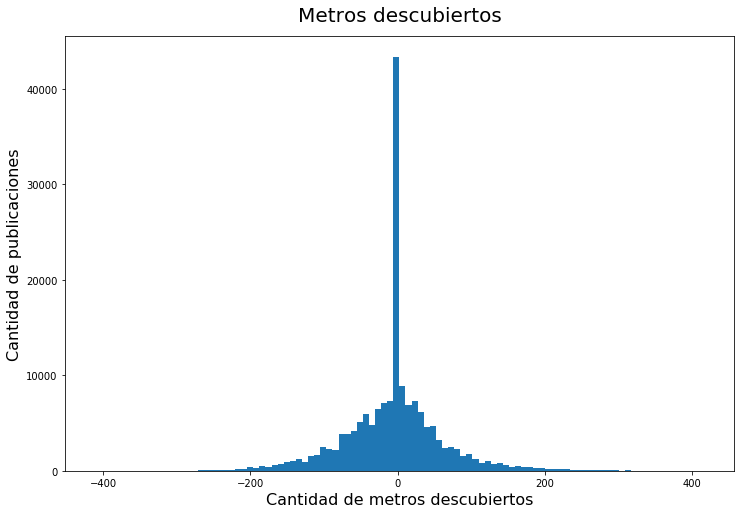

In [9]:
df['metrosdescubiertos'] = df['metrostotales'] - df['metroscubiertos']

plt.hist(df['metrosdescubiertos'].dropna(), bins=100)
plt.title('Metros descubiertos', fontsize=20, y=1.02)
plt.xlabel('Cantidad de metros descubiertos', fontsize=16)
plt.ylabel('Cantidad de publicaciones', fontsize=16)
plt.show()


### Ruido en Latitud y Longitud

In [10]:
states_data = shapereader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
countries_data = shapereader.natural_earth(resolution='10m', category='cultural', name='admin_0_countries')

In [11]:
mex_states = gpd.read_file(states_data,encoding='utf-8')
world = gpd.read_file(countries_data,enconding='utf-8')
mex_states = mex_states.loc[mex_states['admin']=='Mexico']
mex_countrie = world.loc[world['ADMIN']=='Mexico'].geometry
mex_countrie = gpd.GeoDataFrame(mex_countrie)

zonaprop_gpd = df.dropna(subset=['lat','lng'])
zonaprop_gpd = gpd.GeoDataFrame(zonaprop_gpd,geometry=gpd.points_from_xy(zonaprop_gpd.lng,zonaprop_gpd.lat))

puntos_mexico = gpd.sjoin(mex_countrie,zonaprop_gpd,how="right")

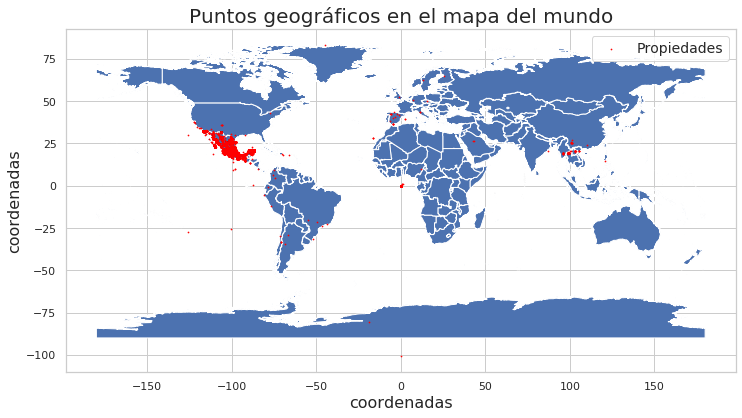

In [33]:
fig, ax = plt.subplots(figsize=(12,8))
world.plot(ax=ax,edgecolor='white')
zonaprop_gpd.plot(color='red',markersize=0.5,ax=ax)
ax.set_title("Puntos geográficos en el mapa del mundo", fontsize=20, y=1.02)
ax.legend(['Propiedades'],prop={'size': 14})
ax.set_xlabel("coordenadas", fontsize=16)
ax.set_ylabel("coordenadas", fontsize=16)
plt.savefig('images/01-mapamundi_todos_puntos.png')
plt.show()

Con el gráfico a continuación comprobamos la siguiente hipótesis: hay ruido en las columnas de latitud y longitud.
Cada punto rojo representa una fila en el dataset. Sin contar los valores nulos, hay 116341 coordenadas geográficas válidas.
Los datos, según Navent, eran solo para México pero hay puntos rojos por todo el mapa. Si la mencionanda empresa no fue quién agregó este ruido, la otra opción válida es que estos "outliers" sean errores de carga por parte de los usuarios de ZonaProp. Los puntos que están fuera de México solo son 897. 

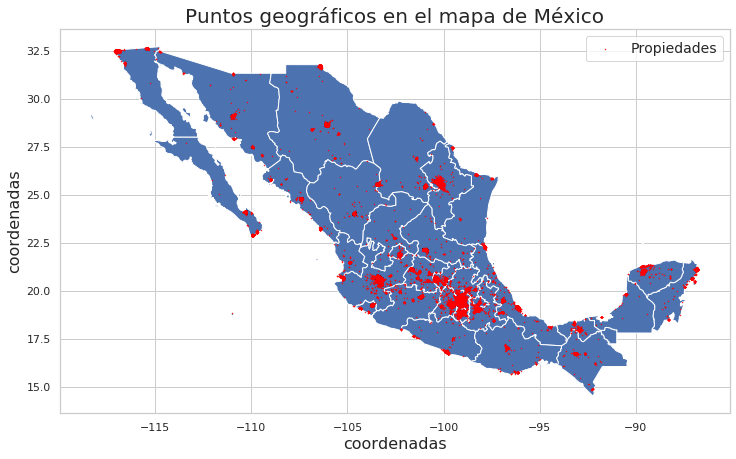

In [32]:
fig, ax = plt.subplots(figsize=(12,8))
mex_states.plot(ax=ax,edgecolor='white')
puntos_mexico.loc[puntos_mexico['index_left']== 155].plot(color='red',markersize=0.2,ax=ax)
ax.set_title("Puntos geográficos en el mapa de México", fontsize=20, y=1.02)
ax.legend(['Propiedades'],prop={'size': 14})
ax.set_xlabel("coordenadas", fontsize=16)
ax.set_ylabel("coordenadas", fontsize=16)
plt.savefig('images/01b-ptos-solo-mexico.png')
plt.show()


Cuando planteamos este gráfico, pensamos que por la cantidad de datos que tenemos, iba a estar todo el mapa de rojo. Nos sorprendió ver que esto no fue así, las ṕublicaciones no están repartidas por toda la región de la misma forma.
Esto significará que los mexicanos usan más ZonaProp en algunas ciudades más que en otras? Esto, en términos absolutos, es verdad y veremos en el siguiente gráfico que, el que estamos analizando, es un gráfico de población. Los estados con más población son aquellos que más publicaciones tiene.

/home/pintopicada/.local/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


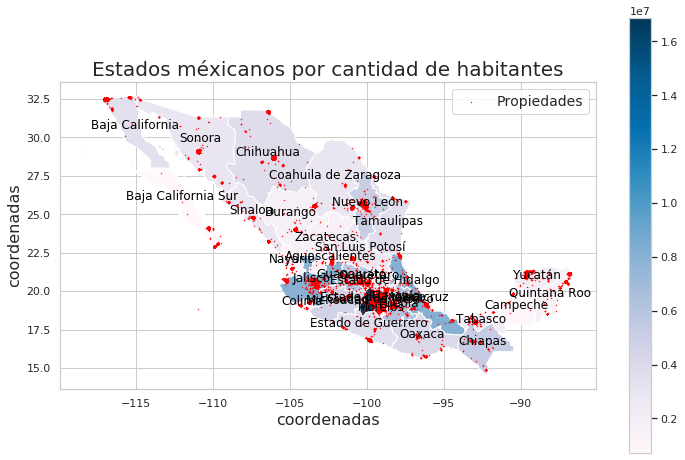

In [34]:
poblacion = pd.read_csv('data/poblacion.csv', names=['name_es','poblacion'],encoding='utf-8')
poblacion.name_es = poblacion.name_es.apply(lambda x: x.strip())
poblacion_df = mex_states.merge(poblacion, on='name_es',how="left")
poblacion_df = gpd.GeoDataFrame(poblacion_df)

fig, ax = plt.subplots(1, 1,figsize=(12,8))

pb = poblacion_df.plot(column='poblacion',ax=ax, legend= True,cmap='PuBu')
poblacion_df.apply(lambda x: pb.annotate(s=x.name_es, xy=x.geometry.centroid.coords[0], ha='center',color='black'),axis=1)
puntos_mexico.loc[puntos_mexico['index_left']== 155].plot(color='red',markersize=0.2,ax=ax)
ax.set_title("Estados méxicanos por cantidad de habitantes", fontsize=20, y=1.02)
ax.legend(['Propiedades'],prop={'size': 14})
ax.set_xlabel("coordenadas", fontsize=16)
ax.set_ylabel("coordenadas", fontsize=16)
plt.savefig('images/heatmap-poblacion-y-publicaciones.png',dpi=100)


En este gráfico, comprobamos que dónde veíamos mucha concentración de puntos rojos, en la mayoría de los casos coincide con los estados méxicanos con mayor cantidad de población.

En las zonas en que la población no es tan alta y hay mucha concentracion de puntos en determinadas regiones, creemos que se deben a que allí están las ciudades más pobladas de ese estado.

## Precio

#### Podemos observar que la distribucion de los precios no respeta una curva normal.


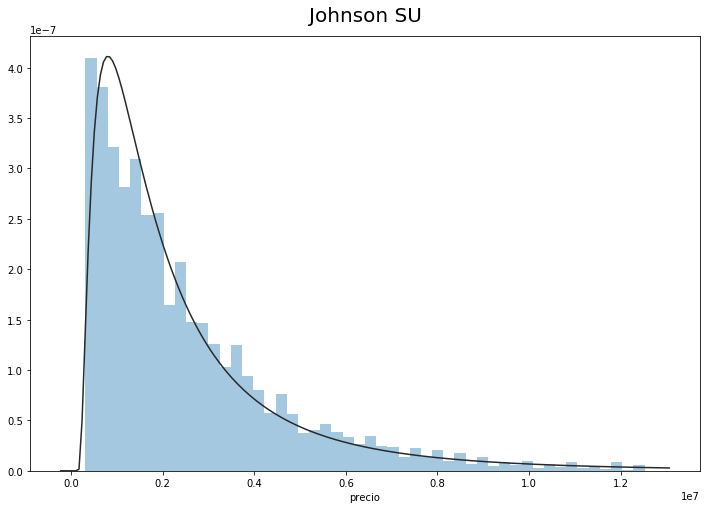

<Figure size 864x576 with 0 Axes>

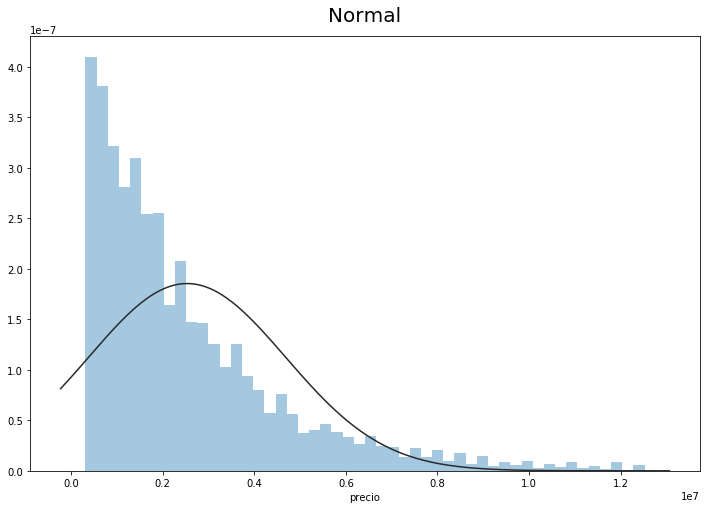

<Figure size 864x576 with 0 Axes>

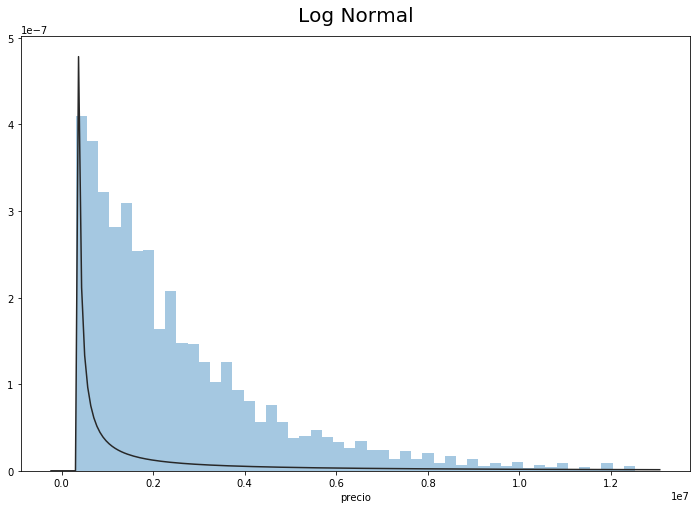

<Figure size 864x576 with 0 Axes>

In [15]:
y = df['precio']
plt.figure(1) 
plt.title('Johnson SU', size=20, y=1.02)
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.show()
plt.savefig('images/03c-precio-johnson.png')

plt.figure(2)
plt.title('Normal', size=20, y=1.02)
sns.distplot(y, kde=False, fit=stats.norm)
plt.show()
plt.savefig('images/03d-precio-normal.png')

plt.figure(3)
plt.title('Log Normal', size=20, y=1.02)
sns.distplot(y, kde=False, fit=stats.lognorm)
plt.show()
plt.savefig('images/03d-precio-log-normal, y=1.02.png')

### Frecuencia y densidad del precio. Distribución asimétrica positiva.

/home/pintopicada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  after removing the cwd from sys.path.


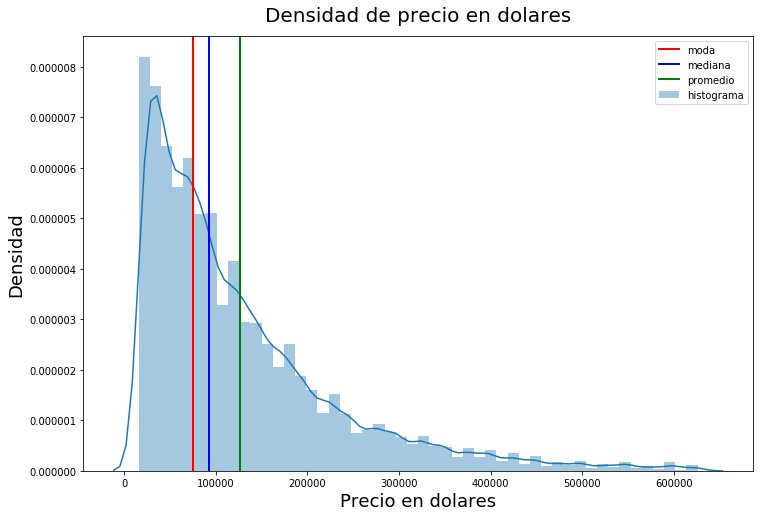

In [16]:
# Plotteamos un density plot para el precio.
mean=df['precio_usd'].mean()
median=df['precio_usd'].median()
mode=df['precio_usd'].mode().get_values()[0]
asimetria_Pearson = ((mean-mode)/df['precio_usd'].std()).round(2)

ax_hist = sns.distplot(df['precio_usd'],)
ax_hist.axvline(mode, color='r', linestyle='-',lw=2)
ax_hist.axvline(median, color='b', linestyle='-',lw=2)
ax_hist.axvline(mean, color='g', linestyle='-',lw=2)
ax_hist.legend(['moda','mediana','promedio','histograma'],)
ax_hist.set_title("Densidad de precio en dolares",fontsize=20, y=1.02)
ax_hist.set_xlabel("Precio en dolares",fontsize=18)
ax_hist.set_ylabel("Densidad", fontsize=18)

plt.savefig('images/01-density-plot-precio-usd.png')

La primera observación que vemos es, tomando como eje de referencia a la moda, es que a su derecha hay más datos que a su izquierda, es por este detalle que esté, la distribución, sesgada hacia a la derecha. Otro dato interesante es que la mayoría de las observaciones se encuentra por debajo de la media. La existencia de valores extremos muy altos es lo que genera una cola larga y fina hacia la derecha.

Para confirmar el tipo de asimetría de una manera "no visual" calculamos el coeficiente de asimetría de Pearson, 0.48. Como es un número mayor que cero nos confirma nuestra hipótesis: es una distribución con asimetría positiva.
La interpretación rápida que hacemos de este gráfico es que, aproximadamente, el 45% de las propiedades cuestan entre 0 y 75000 dólares y que el resto oscila entre 75000 y 600000. Esto es lo que genera la cola larga, el rango para las propiedades más caras es muy amplio.

### Evolución de precios

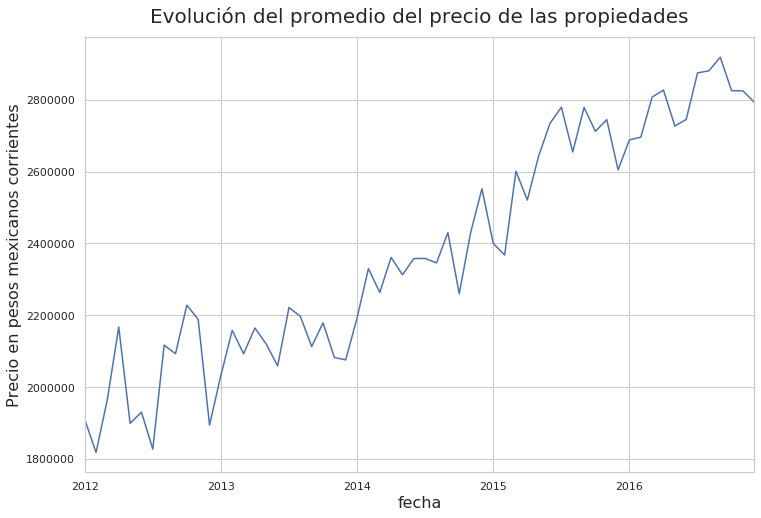

In [29]:

last_price_crte = df.groupby('fecha').precio.mean().tail(1)[0]
first_price_crte = df.groupby('fecha').precio.mean().head(1)[0]
pct_variacion_prop = ((last_price_crte/first_price_crte)-1)*100
#print(pct_variacion_prop)

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title("Evolución del promedio del precio de las propiedades", fontsize=20, y=1.02)
ax.set_ylabel("Precio en pesos mexicanos corrientes", fontsize=16)
ax.set_xlabel("Fecha", fontsize=16)


df.groupby('fecha').precio.mean().plot(kind='line')
plt.savefig("images/02-evolucion-promedio-precio.png")

Este gráfico muestra la evolución del promedio de las propiedades de nuestro dataset. Desde el 2012 hasta el mes de diciembre del 2016, aumentaron un **46,20%**.

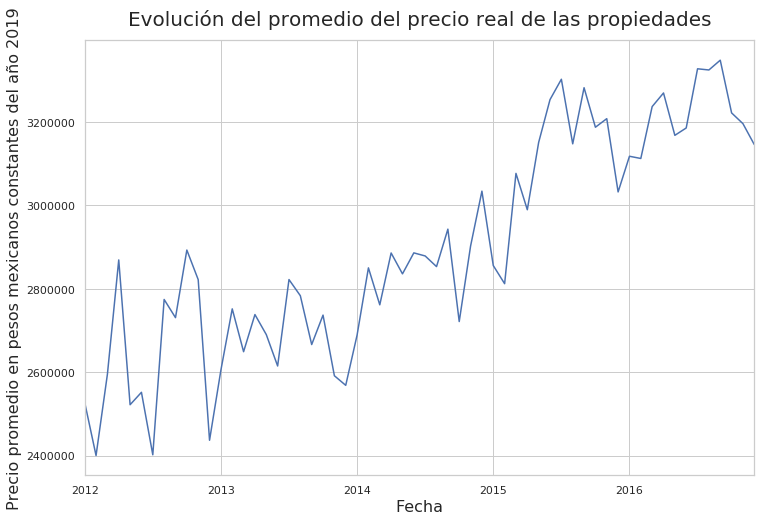

In [35]:
last_price_ctte = df.groupby('fecha').precio_constantes.mean().tail(1)[0]
first_price_ctte = df.groupby('fecha').precio_constantes.mean().head(1)[0]
pct_variacion_prop = ((last_price_ctte/first_price_ctte)-1)*100

first_indice = df.sort_values(by='fecha').iloc[0].indice
last_indice = df.sort_values(by='fecha').iloc[-1].indice
pct_variacion_infla = ((last_indice/first_indice)-1)*100

fig = plt.subplots(figsize=(12,8))
ax = serie_precios_reales = df.groupby('fecha').precio_constantes.mean().plot()

ax.set_title("Evolución del promedio del precio real de las propiedades", fontsize=20, y=1.02)
ax.set_ylabel("Precio promedio en pesos mexicanos constantes del año 2019", fontsize=16)
ax.set_xlabel("Fecha", fontsize=16)

plt.savefig("images/03-evolucion-precios-reales.png")
plt.show()


Luego de analizar la evolución de los precios por año, nos dimos cuenta de que sin tener en cuenta la inflación no se pueden comparar momentos distintos.

La metodología que utilizamos fue descargar una serie de inflación de méxico, hacer un merge con nuestro dataset y deflactar los precios. Luego, para gráficar, agrupamos los datos por año y calculamos el promedio. 
Con este gráfico podemos afirmar que los precios de las propiedades en méxico aumentaron año a año, desde el 2012 hasta el 2016. Los precios reales, en promedio, subieron un **24,45% en 4 años**. En Cambio, la inflación en México fue del 17,48% para el mismo periodo.

Esto significa que, para el periodo analizado, las propiedades fueron una reserva de valor para los mexicanos.

## Correlación general entre variables

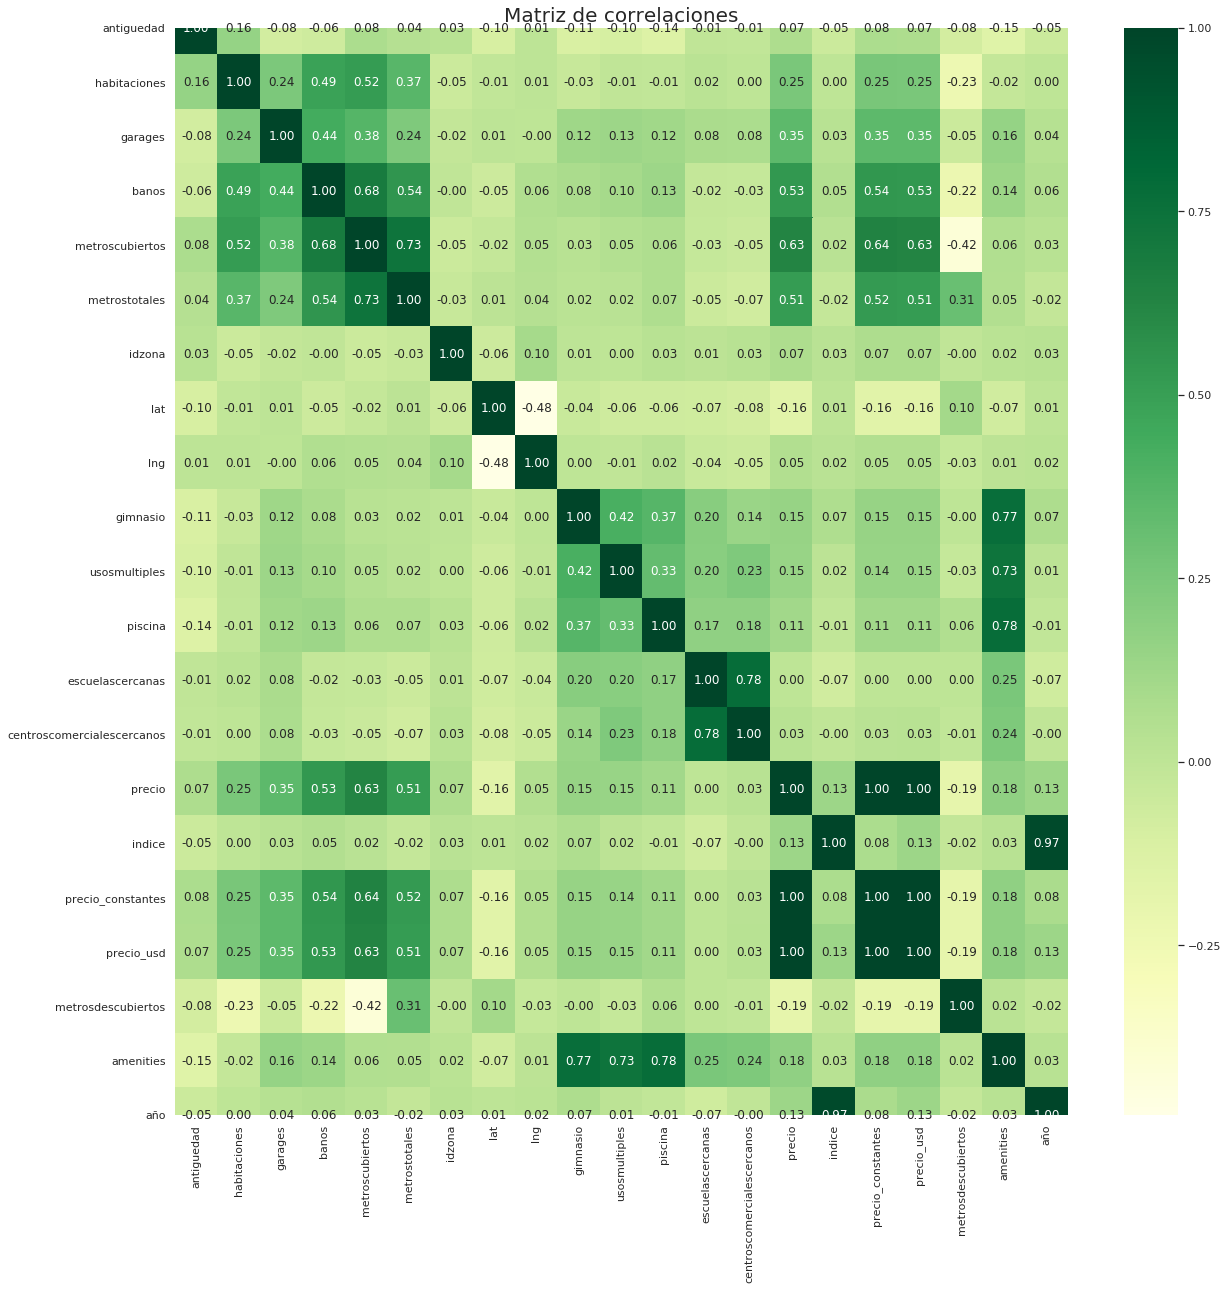

In [36]:
# Creamos una matriz de correlaciones solo para las variables cuantitativas.
#variables_cuantitativas = ['precio', 'metros', 'maxMetros', 'metrostotales','metroscubiertos','banos','garages','habitaciones','antiguedad']
plt.figure(figsize=(20,20))
cm= df.corr()
hm = sns.heatmap(cm, annot=True, fmt='.2f', cmap="YlGn")
hm.set_title('Matriz de correlaciones', fontsize=20, y=1.02)

plt.savefig("images/03-b-evolucion-precios-reales.png")

plt.show()


## Tipo de propiedades

#### Diferentes tipos de propiedades

In [20]:
df['tipodepropiedad'].unique()

array(['Apartamento', 'Casa en condominio', 'Casa', 'Terreno',
       'Local en centro comercial', 'Bodega comercial', 'Edificio',
       'Local Comercial', 'Terreno comercial', 'Otros', 'Villa',
       'Oficina comercial', 'Rancho', 'Casa uso de suelo',
       'Nave industrial', 'Quinta Vacacional', 'Departamento Compartido',
       nan, 'Inmuebles productivos urbanos', 'Huerta', 'Duplex',
       'Terreno industrial', 'Lote', 'Garage', 'Hospedaje'], dtype=object)

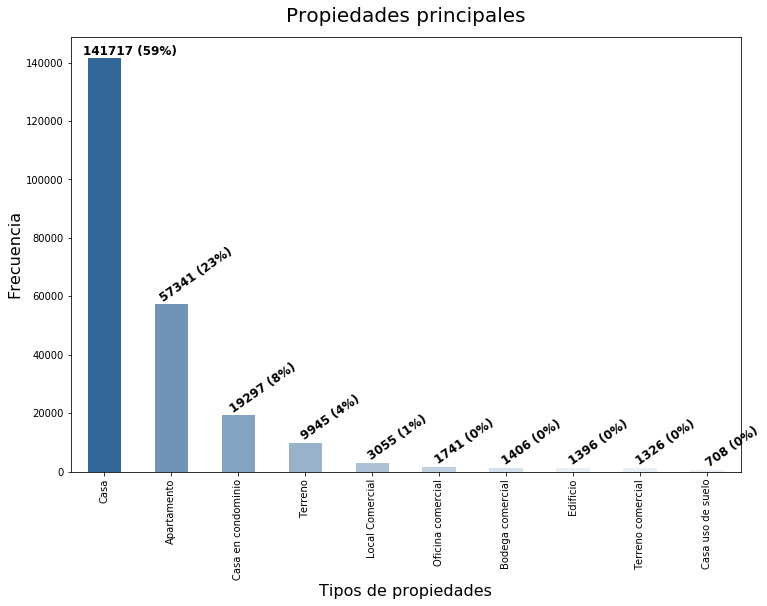

In [21]:
tiposPrincipales = df.tipodepropiedad.value_counts().sort_values(kind="quicksort", ascending=False).to_frame()
tiposPrincipales['porcentaje'] = tiposPrincipales.values / tiposPrincipales.values.sum() * 100
tiposPrincipales = tiposPrincipales.head(10)

ax = tiposPrincipales.tipodepropiedad.plot(kind='bar', color=[(0.2, 0.4, 0.6, 1)
                                                            , (0.2, 0.4, 0.6, 0.7)
                                                            , (0.2, 0.4, 0.6, 0.6)
                                                            , (0.2, 0.4, 0.6, 0.5)
                                                            , (0.2, 0.4, 0.6, 0.4)
                                                            , (0.2, 0.4, 0.6, 0.3)
                                                            , (0.2, 0.4, 0.6, 0.2)
                                                            , (0.2, 0.4, 0.6, 0.1)
                                                            , (0.2, 0.4, 0.6, 0.1)
                                                            , (0.2, 0.4, 0.6, 0.1)                                                             
                                                             ])
# plt.figsize((12,8))
ax.set_title('Propiedades principales', fontsize=20, y=1.02)
ax.set_xlabel('Tipos de propiedades', fontsize=16)
ax.set_ylabel('Frecuencia', fontsize=16)
ax.set_xticklabels(tiposPrincipales.tipodepropiedad.index)

rects = ax.patches
# Make some labels.
labels = [str(int(row.tipodepropiedad)) + ' (' + str(int(row.porcentaje)) + '%)' for index, row in tiposPrincipales.iterrows()]
angle = 0
i = 0
for rect, label in zip(rects, labels):
    if i != 0:
        angle = 35
    height = rect.get_height()
    ax.text(rect.get_x() + (rect.get_width() * 5 / 4) , height + 5, label,
            ha='center', va='bottom', fontsize=12, fontweight='bold', rotation=angle)
    i += 1

plt.savefig('images/04-tipos-propiedades.png')
plt.show()


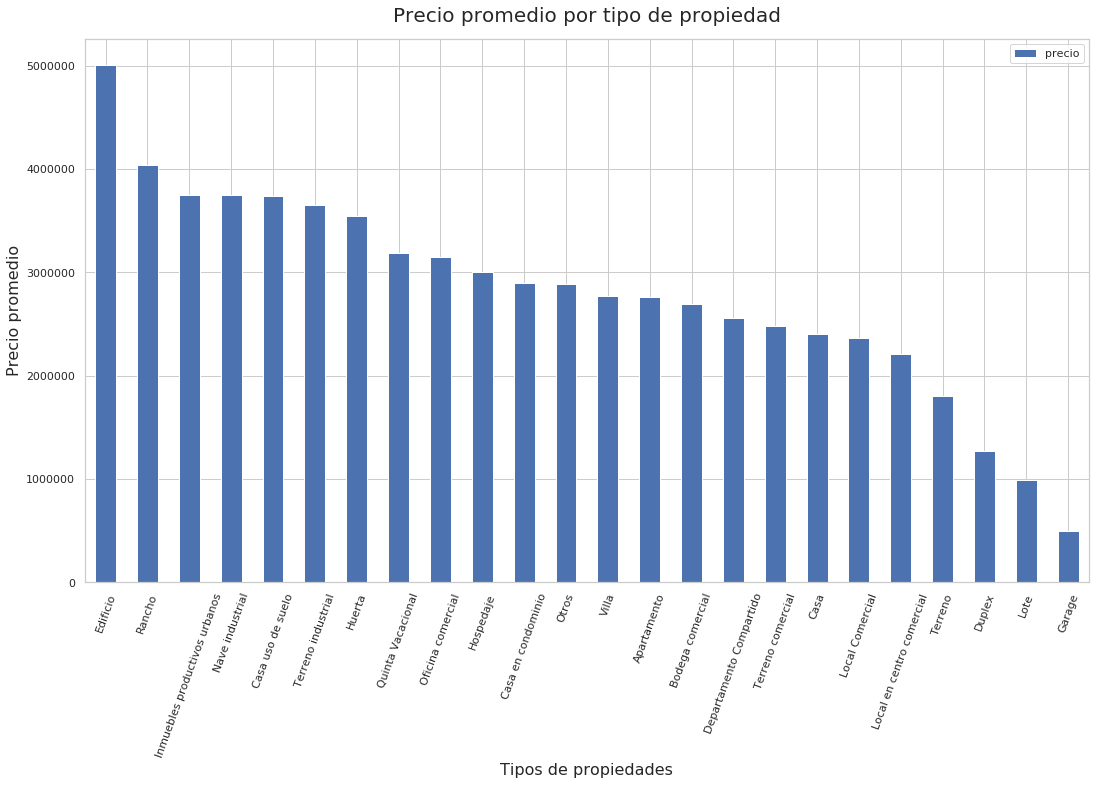

In [38]:
ax = df.groupby('tipodepropiedad').agg({'precio': 'mean'})\
       .sort_values('precio', ascending=False)\
       .plot(kind='bar', figsize=(18, 10), rot=70, title="Precio promedio por tipo de propiedad");
ax.set_title('Precio promedio por tipo de propiedad', fontsize=20, y=1.02)
ax.set_xlabel('Tipos de propiedades', fontsize=16)
ax.set_ylabel('Precio promedio', fontsize=16)


plt.savefig('images/05-precios-tipos-propiedades.png')
plt.show()


## Regiones

In [23]:
# merge regiones
regiones = pd.read_csv('data/regionesMexico.csv',encoding = "UTF-8")
df = df.merge(regiones,on='provincia', how='inner')

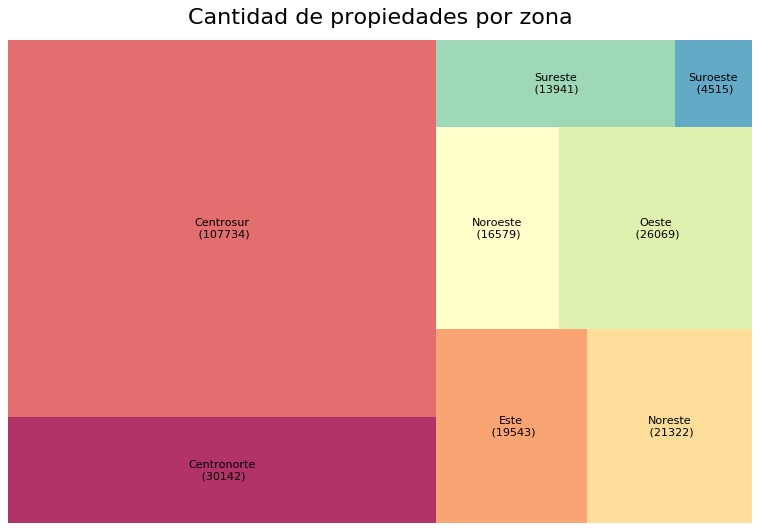

In [24]:
# Prepare Data
df_zonas = df.groupby('región').size().reset_index(name='counts')
labels = df_zonas.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
sizes = df_zonas['counts'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

# Draw Plot
plt.figure(figsize=(12,8), dpi= 80)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

# Decorate
plt.title('Cantidad de propiedades por zona', fontsize=20, y=1.02)
plt.axis('off')
plt.savefig('images/06-zonas-cant.png')
plt.show()


## Amenities

Hay ciertos elementos que podrían considerarse lujos a la hora de comprar una propiedad. Identificamos dentro de ese grupo los siguientes: Gimnasio, usos múltiples, piscina. Los agrupamos dentro de una categoría que llamamos amenities. 

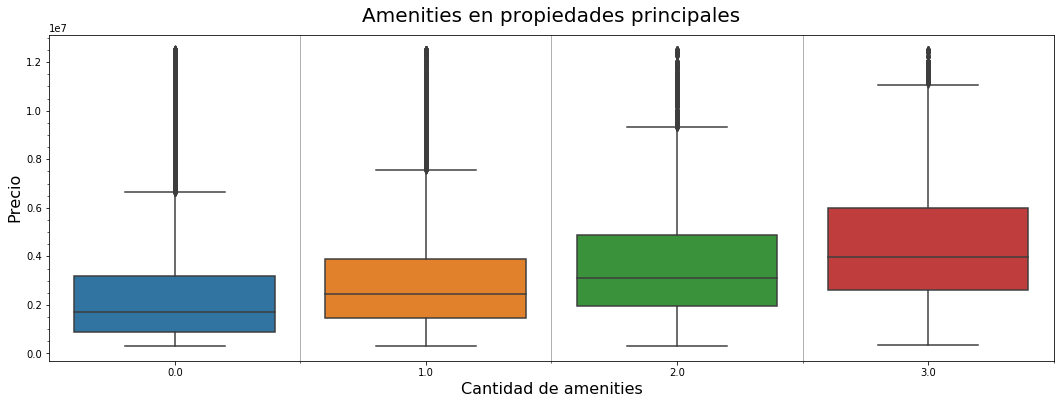

In [25]:
df['amenities'] = df.gimnasio + df.usosmultiples + df.piscina
dfProps = df[df.tipodepropiedad.isin(tiposPrincipales.index)]

from matplotlib.ticker import AutoMinorLocator
fig = plt.figure(figsize=(18,6))
ax1 = sns.boxplot('amenities', "precio", data=dfProps)

ax1.set_title('Amenities en propiedades principales', fontsize=20, y=1.02)
ax1.set_xlabel('Cantidad de amenities', fontsize=16)
ax1.set_ylabel('Precio', fontsize=16)
ax1.minorticks_on()
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.grid(which='minor', axis='x', linewidth=1)

plt.savefig('images/07-amenities-cajas.png')
plt.show()

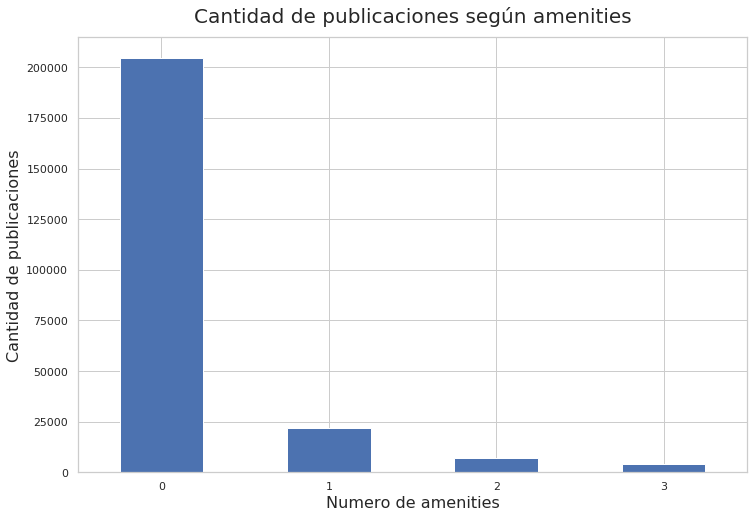

In [39]:
plt.figure(figsize=(12, 8))
labels = [str(int(index[0])) for index, row in dfProps.groupby("amenities").amenities.value_counts().to_frame().iterrows()]

ax = dfProps.groupby("amenities").amenities.value_counts().plot(kind='bar')
ax.set_title('Cantidad de publicaciones según amenities', fontsize=20, y=1.02)
ax.set_xlabel('Numero de amenities', fontsize=16)
ax.set_ylabel('Cantidad de publicaciones', fontsize=16)

ax.set_xticklabels(labels, rotation=0)

plt.savefig('images/08-amenities-cant.png')
plt.show()


## Estacionalidad: mes / día / año

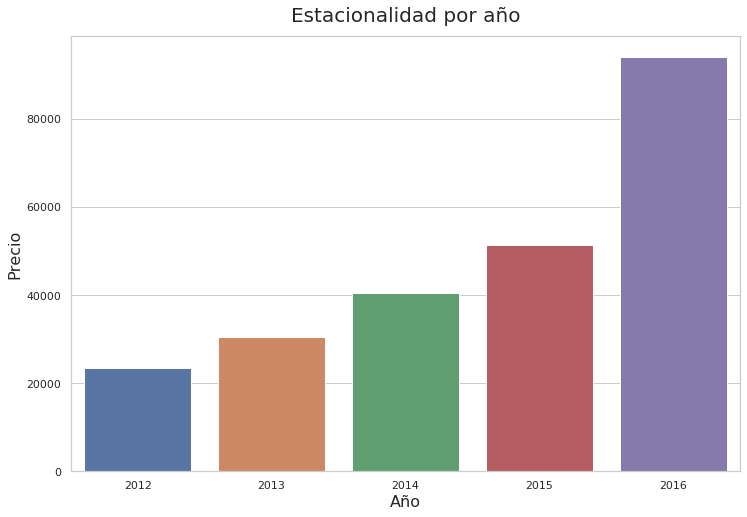

In [27]:
dfViviendas = df
dfViviendas['año'] = dfViviendas.fecha.dt.year

df3 = dfViviendas.groupby(['año'])['precio'].count().to_frame().reset_index()
sns.set(style="whitegrid")

ax = sns.barplot(x="año", y="precio", data=df3)
ax.set_title('Estacionalidad por año', fontsize=20, y=1.02)
ax.set_xlabel('Año', fontsize=16)
ax.set_ylabel('Precio', fontsize=16)

plt.savefig('images/09-estacionalidad-año.png')
plt.show()


In [28]:
df['mes-año'] = (df.fecha - MonthBegin(1)).dt.strftime('%Y-%m')
df3 = df.groupby(['mes-año'])['precio'].count().to_frame().reset_index()
plt.figure(figsize=(24,9))
sns.set(style="whitegrid")
sns.lineplot(x="mes-año", y="precio", data=df3)
# sns.scatterplot(x="mes-año", y="precio", data=df3)
plt.ylabel('Cantidad de publicaciones', size=16)
plt.xlabel('Mes-Año', size=16)
plt.xticks(rotation=45)

plt.savefig('images/10-estacionalidad-año-mes.png')
plt.show()


IncompatibleFrequency: Input has different freq=-1MS from PeriodArray(freq=M)

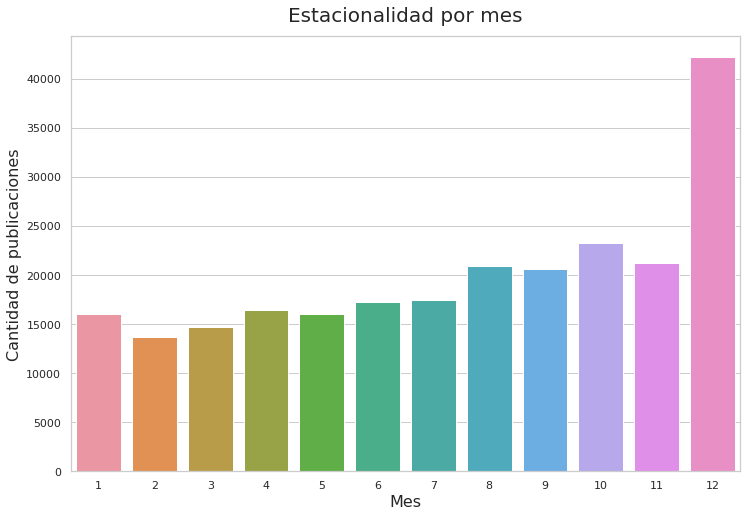

In [40]:
dfViviendas['mes'] = dfViviendas.fecha.dt.month

df3 = dfViviendas.groupby(['mes'])['precio'].count().to_frame().reset_index()
sns.set(style="whitegrid")

# plt.figure(figsize=(12, 8))
ax = sns.barplot(x="mes", y="precio", data=df3)
ax.set_title('Estacionalidad por mes', fontsize=20, y=1.02)
ax.set_xlabel('Mes', fontsize=16)
ax.set_ylabel('Cantidad de publicaciones', fontsize=16)

plt.savefig('images/11-estacionalidad-mes.png')
plt.show()


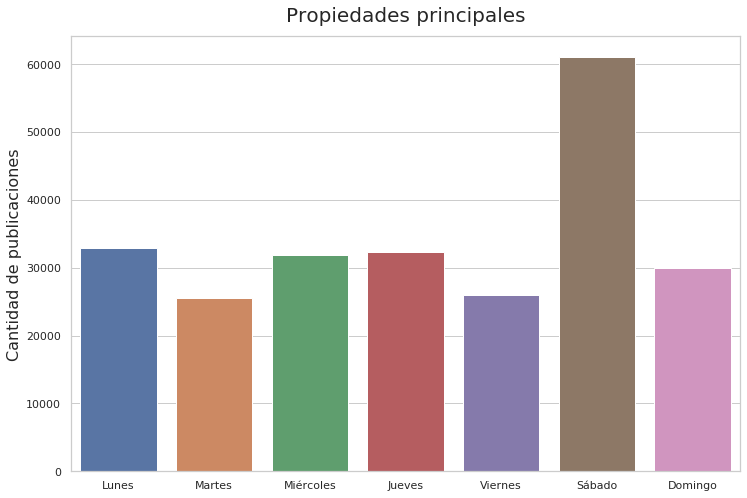

In [41]:
dfViviendas['dia'] = dfViviendas.fecha.dt.dayofweek

df3 = dfViviendas.groupby(['dia'])['precio'].count().to_frame().reset_index()
sns.set(style="whitegrid")

# plt.figure(figsize=(12, 8))
ax = sns.barplot(x="dia", y="precio", data=df3)
ax.set_title('Propiedades principales', fontsize=20, y=1.02)
ax.set_xlabel('', fontsize=16)
ax.set_ylabel('Cantidad de publicaciones', fontsize=16)
plt.xticks(np.arange(7), ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'])

plt.savefig('images/12-estacionalidad-dia-semana.png')
plt.show()


## Antiguedad

#### Antiguedad promedio por provincia

In [42]:
df.groupby('provincia').agg({'antiguedad':'mean'}).sort_values('antiguedad')

,antiguedad
provincia,
Baja California Sur,2.46
Yucatán,3.07
Hidalgo,3.47
Tlaxcala,3.69
Querétaro,3.70
Campeche,3.91
San luis Potosí,3.98
Quintana Roo,4.54
Puebla,4.55


### Precio promedio por tipo de propiedad

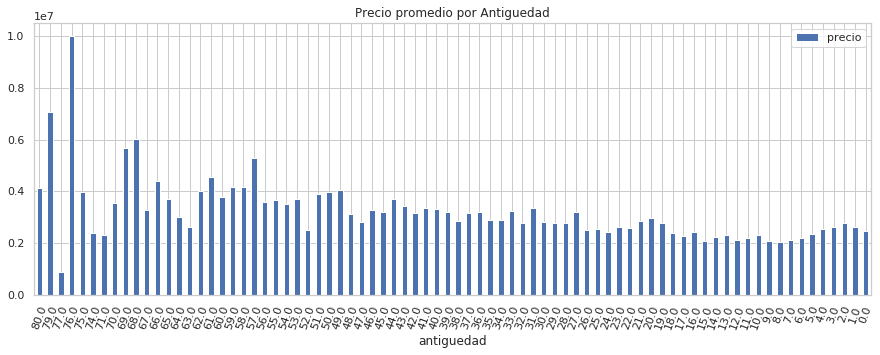

In [43]:
df.groupby('antiguedad').agg({'precio': 'mean'})\
    .sort_values('antiguedad', ascending=False)\
    .plot(kind='bar', figsize=(15, 5), rot=70, title="Precio promedio por Antiguedad");

plt.savefig('images/12-antiguedad-precio-prom.png')
plt.show()


AttributeError: 'Text' object has no property 'rotate'

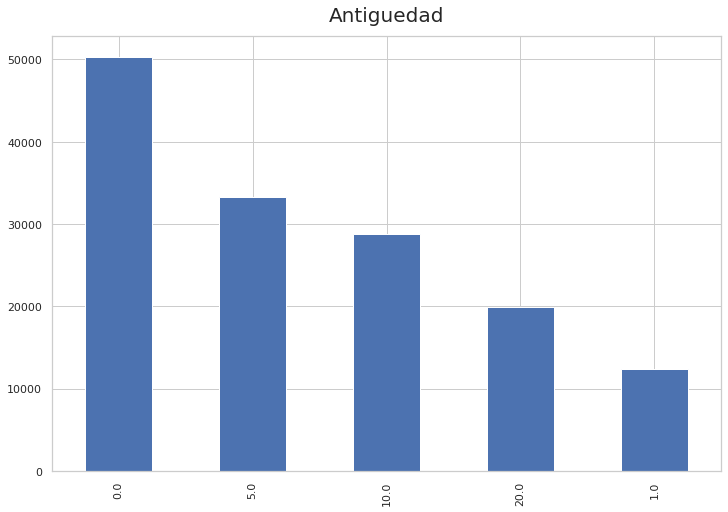

In [44]:
# plt.figure(figsize=(12, 8))

ax = df.groupby(by=['antiguedad']).size().sort_values(ascending=False).nlargest(5).plot(kind='bar')

ax.set_title('Antiguedad', fontsize=20, y=1.02)
ax.set_xlabel('', fontsize=16, rotate=45)
ax.set_ylabel('', fontsize=16)

plt.savefig('images/13-antiguedad-prom.png')
plt.show()


## Análisis de Descripciones

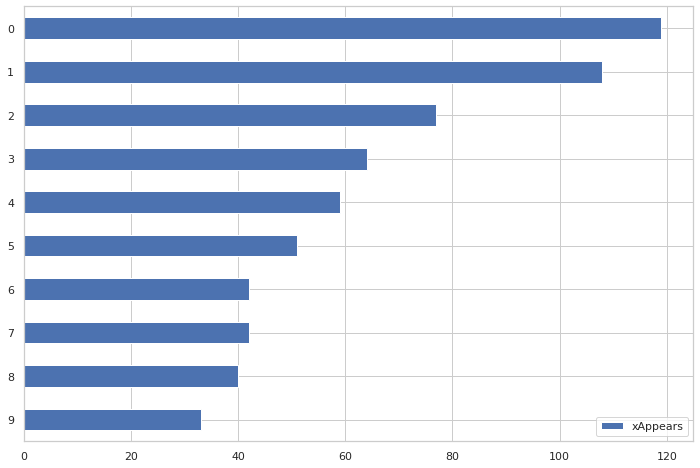

In [45]:
desc_unicas = df['descripcion'].value_counts().to_dict()
desc_df = pd.DataFrame(list(desc_unicas.items()), columns=['Content', 'xAppears'])
desc_df.sort_values(by='xAppears', ascending=True).tail(10).plot(kind='barh')


realtors,0,1
year,,
2012,22947,587
2013,29411,975
2014,39269,1173
2015,49361,2108
2016,89413,4601


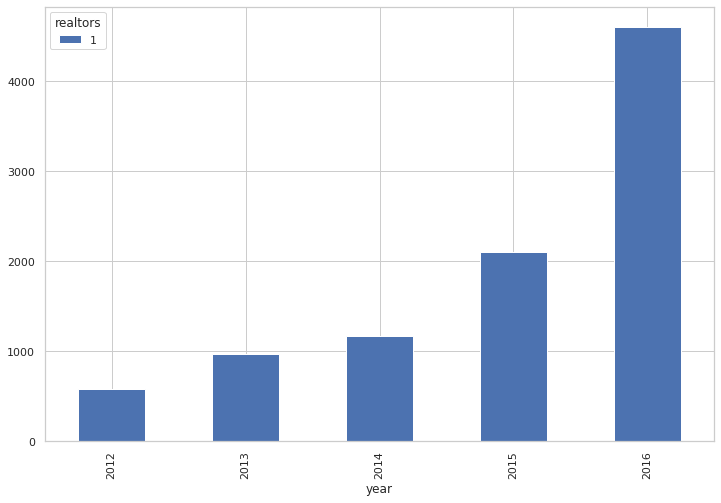

In [46]:
df = df.merge(desc_df,how='left',left_on='descripcion',right_on='Content')
def GetRealtor(x):
    if x > 1:
        return '1'
    else:
        return '0'

df['realtors']= df.xAppears.apply(GetRealtor)
df['year'] = df.fecha.dt.year

df[(df['realtors'] == '1')].groupby(['year'])['realtors'].value_counts().unstack().plot(kind = 'bar')
df.groupby(['year'])['realtors'].value_counts().unstack()

In [47]:
df[df.tipodepropiedad.isin(['Apartamento','Casa','Casa en condominio','Terreno']) & (df.year == 2016)].\
groupby(['provincia','tipodepropiedad','year','realtors'])['precio'].mean().unstack()

realtors                                               0          1
provincia             tipodepropiedad    year                      
Aguascalientes        Apartamento        2016 2518333.33        nan
                      Casa               2016 1681422.00 1357543.33
                      Casa en condominio 2016 1997854.25        nan
                      Terreno            2016 1128288.86  398000.00
Baja California Norte Apartamento        2016  727695.10  591219.40
...                                                  ...        ...
Yucatán               Casa en condominio 2016 2479871.73 3176000.00
                      Terreno            2016 1224550.91        nan
Zacatecas             Casa               2016 1133333.33 1750000.00
                      Casa en condominio 2016        nan 1750000.00
                      Terreno            2016 1152250.00        nan

[127 rows x 2 columns]

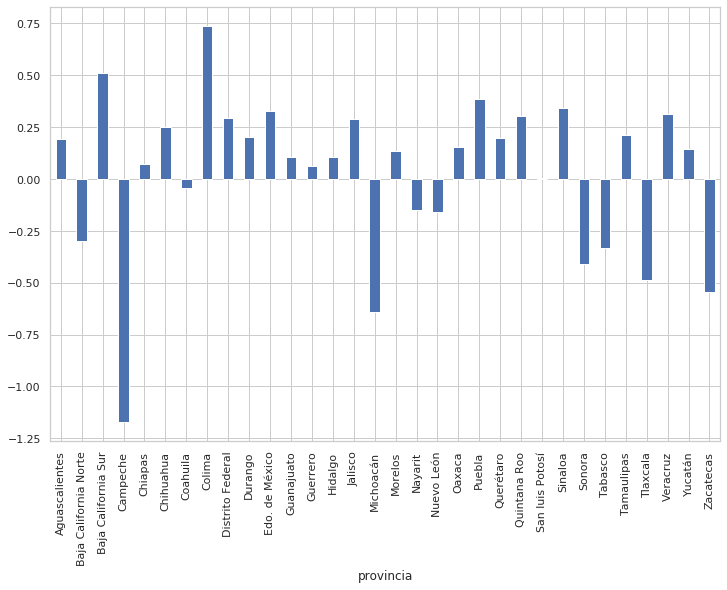

<Figure size 864x576 with 0 Axes>

In [48]:
real_casa16 = df[df.tipodepropiedad.isin(['Casa']) & (df.year == 2016)] \
                                   .groupby(['provincia','realtors'])['precio'] \
                                   .mean() \
                                   .unstack()
real_casa16['delta'] = (real_casa16['0'] - real_casa16['1']) / real_casa16['0']
real_casa16['delta'].plot(kind='bar')


plt.show()
plt.savefig('images/14-realtors-casa-2016.png')

## Correlación de Google Trends con caracteristicas de venta

In [49]:
df_trend = df
df_trend['fecha']= pd.to_datetime(df_trend['fecha'], errors='coerce')
df_trend['year']=df_trend.fecha.dt.year
df_trend['precio_constantes'] = (df_trend['precio']/df_trend['indice'])*100
# Preparando datos
sentiment = df_trend.merge(trends,how='inner',on='fecha')
sentiment2 = sentiment[['tipodepropiedad', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'fecha',
       'precio', 'year', 'fecha_mes',
       'precio_constantes', 'Month', 'comprar casa: (Mexico)',
       'vender casa: (Mexico)']]
sentimentCasas = sentiment.loc[(sentiment2.tipodepropiedad=='Casa') & (sentiment2.habitaciones==3)]
sentimentCasas['month'] = sentimentCasas.fecha_mes.dt.month
corrSentimentCasas = sentimentCasas[['antiguedad','garages',\
                                     'metroscubiertos','metrostotales','year','month',\
                                     'precio_constantes','comprar casa: (Mexico)','vender casa: (Mexico)']]

TypeError: Passing PeriodDtype data is invalid.  Use `data.to_timestamp()` instead

In [50]:
cor = corrSentimentCasas.corr()
upper = cor.where(np.triu(np.ones(cor.shape), k=1).astype(np.bool))


fig, ax = plt.subplots(figsize=[20,12])

plt.title("correlation Matrix", fontsize = 20, y=-0.05)
image = ax.imshow(cor, cmap = 'RdBu')

plt.xticks(np.arange(len(cor.columns)),cor.columns, rotation = 'vertical')
ax.xaxis.tick_top()
plt.yticks(np.arange(len(cor.columns)),cor.columns, rotation = 'horizontal')
fig.colorbar(image, ax=ax)
plt.rcParams['grid.color'] = "w"
plt.grid()

plt.show()
plt.savefig('images/15-sentiment.png')

NameError: name 'corrSentimentCasas' is not defined

In [51]:
#order the correlations and their associated column
minCorrValue = 0.05
goodCorrValue = 0.6

corrOrdered = list(upper['precio_constantes'].copy().sort_values())
numNan = upper['precio_constantes'].isnull().sum()
colOrdered = [upper.columns[list(upper['precio_constantes']).index(x)] for x in corrOrdered[:-numNan]]

# We have colOrdered, corrOrdered, numNan, lowCorrelatedColumns
plt.savefig('images/15-sentiment.png')
lowCorrelatedColumns, highCorrelatedColumns = [], []

#get the high and low correlated columns + color
colorList= ['b']*len(colOrdered)
for x in corrOrdered:
    if abs(x) in [x for x in list(upper['precio_constantes'].abs()) if x<minCorrValue]:
        colorList[corrOrdered.index(x)] = 'r'                    #undecoralated columns are red
        lowCorrelatedColumns.append(colOrdered[corrOrdered.index(x)])
    if abs(x) in [x for x in list(upper['precio_constantes'].abs()) if x>goodCorrValue]:
        colorList[corrOrdered.index(x)] = 'lime'                    #undecoralated columns are red
        highCorrelatedColumns.append(colOrdered[corrOrdered.index(x)])
                        
            
plt.figure(figsize=[10,10])
plt.barh(colOrdered,corrOrdered[:-numNan], color=colorList)
plt.title("Influence (Correlation) of each column on the selling Price", fontsize=20)
plt.tick_params(labelsize=15)
plt.legend( ['relevant Columns','good'])
plt.axvline(x= minCorrValue, c='r')
plt.fill_between([-minCorrValue,minCorrValue], [len(upper),len(upper)],[-1,-1], alpha = 0.5, color = 'red')
plt.axvline(x= -minCorrValue, c='r')
plt.axvline(x= goodCorrValue, c='g')
ax = plt.gca()
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([-minCorrValue,minCorrValue,goodCorrValue])

#color the yticks
for x in lowCorrelatedColumns:
        ax.get_yticklabels()[colOrdered.index(x)].set_color("red")
for x in highCorrelatedColumns:
        ax.get_yticklabels()[colOrdered.index(x)].set_color("green")

plt.show()
plt.savefig('images/16-sentiment-2.png')

NameError: name 'upper' is not defined